In [1]:
### 
### 1) For the upcoming year (2020) where are the most/least expensive airbnb 
### listings in Seattle and how do prices change throughout the year.
### 

In [2]:
import numpy as np
import pandas as pd
from itertools import compress
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

### Listings file contains characteristics of each listing
###               each row contains unique listing id
###
### Calendar file contains individual date availability going forward 
###               for a year for each listing
### 
listings_df = pd.read_csv('./listings_09_19.csv')
calendar_df = pd.read_csv('./calendar_09_19.csv')

In [3]:
### Verify there is a single unique listing_id per row
print(len(listings_df.id.unique()))
print(listings_df.shape[0])

9040
9040


In [4]:
### For this look, we only need location data from listings and time, price data from calendar
listings_df.rename(columns={'neighbourhood_group_cleansed': 'Neighborhood'},inplace = True)
nbhd_df = listings_df[['Neighborhood','id']].copy()
nbhd_count_df = nbhd_df.groupby(['Neighborhood']).agg(np.size).sort_values('id',ascending = False)
print(nbhd_count_df)
## Can sort and make bar graph 

                       id
Neighborhood             
Other neighborhoods  1682
Downtown             1662
Capitol Hill          930
Central Area          809
Queen Anne            645
West Seattle          481
Ballard               471
Cascade               446
Rainier Valley        429
Beacon Hill           316
Delridge              266
University District   244
Northgate             216
Magnolia              165
Lake City             151
Seward Park            88
Interbay               39


In [5]:
##### 'Other neighborhoods' is not descriptive, so discover zipcodes
#####
###nbhd_zip = listings_df[listings_df.Neighbourhood == 'Other neighborhoods'].groupby('zipcode').agg(np.size).reset_index()
###print(nbhd_zip)

###    98103 Freemont, Licton Springs
###    98105 NE Seattle 
###    98115 Northeast Seattle , MapleLeaf , Apple University, north of Lake Union
###    The majority of these are North / Northeast Seattle 
###    So rename , eliminate the rest for now
###    Improve the correspondence and breakdown of 'Other neighborhoods' later, perhaps using lat/lon

listings_df.loc[((listings_df.zipcode == '98103') |  (listings_df.zipcode == '98105') | (listings_df.zipcode == '98115')) &
                (listings_df.Neighborhood == 'Other neighborhoods'),'Neighborhood'] = 'N_NE_Seattle'

listings_df = listings_df[listings_df != 'Other neighborhoods']  ## Eliminates 407 entrees
listings_df.groupby('Neighborhood').agg(np.size).reset_index().sort_values('id',ascending = False)
nbhd_df = listings_df[['Neighborhood','id']].copy()

In [6]:
##listings_df.groupby('property_type').agg(np.size).reset_index().sort_values('id',ascending = False)

In [7]:
##### Neighborhood does not need to be cleaned
##### Cleaning  calendar_df in this cell
calendar_df.date  = pd.to_datetime(calendar_df.date)
calendar_df.price = calendar_df.price.astype(str).str.replace('$','')
calendar_df.price = calendar_df.price.astype(str).str.replace(',','').astype('float64')

### Can show that only in about 1% of cases adjusted_price is different than price
### and I don't know how to interpret, so drop this
calendar_df.drop(['adjusted_price'],axis=1,inplace=True) 
calendar_df.listing_id.astype('int64',inplace = True) 
calendar_df.rename(columns={'listing_id': 'id'},inplace = True)
calendar_df.head()

,id,date,available,price,minimum_nights,maximum_nights
0,2318,2019-09-22,t,475.0,30,1000
1,2318,2019-09-23,t,475.0,30,1000
2,2318,2019-09-24,t,475.0,30,1000
3,2318,2019-09-25,f,475.0,30,1000
4,2318,2019-09-26,f,475.0,30,1000


In [8]:
##### Merge listings info and calendar info on listings id
##### Note roughly a full year of data for each id
data_df = pd.merge(nbhd_df,calendar_df,  on='id', how='inner')
print(data_df.shape[0])
print(nbhd_df.shape[0] * 364)
print(data_df.head())

3299600
3290560
   Neighborhood    id       date available  price  minimum_nights  \
0  Central Area  2318 2019-09-22         t  475.0              30   
1  Central Area  2318 2019-09-23         t  475.0              30   
2  Central Area  2318 2019-09-24         t  475.0              30   
3  Central Area  2318 2019-09-25         f  475.0              30   
4  Central Area  2318 2019-09-26         f  475.0              30   

   maximum_nights  
0            1000  
1            1000  
2            1000  
3            1000  
4            1000  


In [9]:
##### First look at summary of all prices,
np.sum(data_df.isnull())
data_df['price'].describe()

count    3.299600e+06
mean     1.556720e+02
std      1.527780e+02
min      1.000000e+01
25%      8.000000e+01
50%      1.190000e+02
75%      1.820000e+02
max      6.596000e+03
Name: price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bc9acf8>]],
      dtype=object)

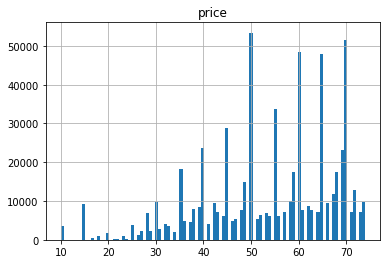

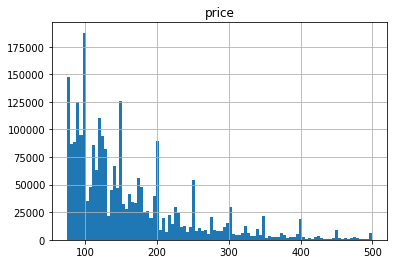

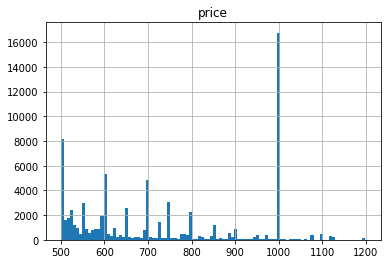

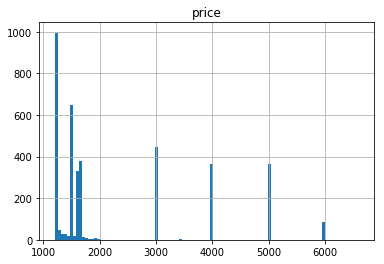

In [10]:
##### We define four categories for prices (per night)
## low:            price < $75
## norm:  $75  <=  price < $500
## high:  $500 <=  price < $1200
## exhih: $1200<=  price

data_low_df    = data_df[data_df.price  < 75.00].copy()
data_norm_df   = data_df[(data_df.price < 500.0)  & (data_df.price >= 75.00)].copy()
data_high_df   = data_df[(data_df.price < 1200.0) & (data_df.price >= 500.0)].copy()
data_exhigh_df = data_df[data_df.price >= 1200.0].copy()


data_low_df['price'].to_frame().hist(bins=100)
data_norm_df['price'].to_frame().hist(bins=100)
data_high_df['price'].to_frame().hist(bins=100)
data_exhigh_df['price'].to_frame().hist(bins=100)

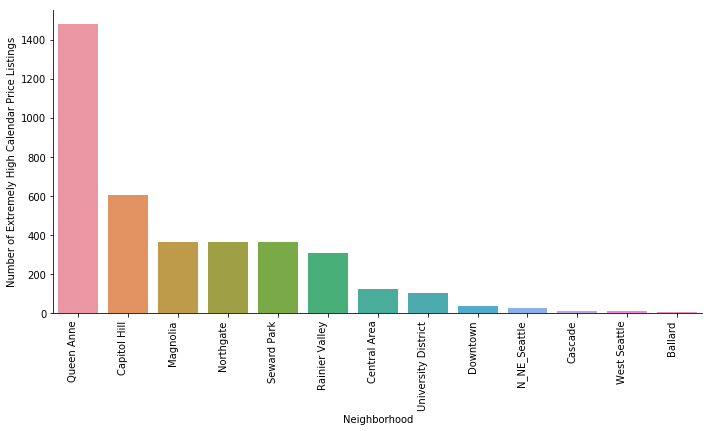

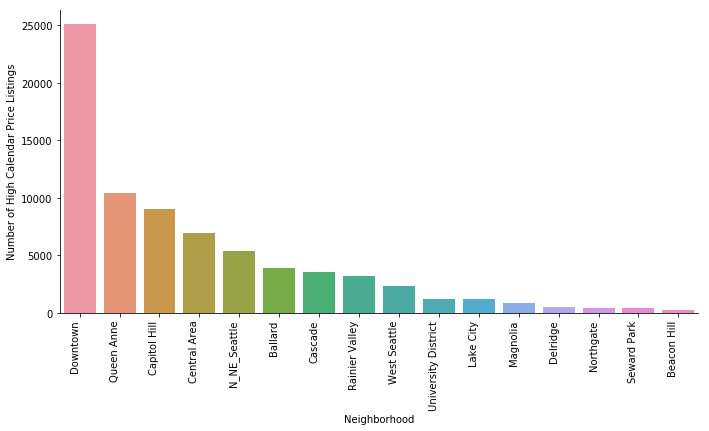

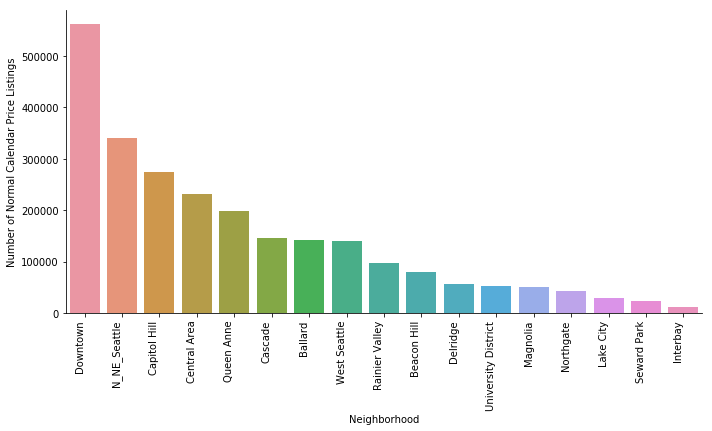

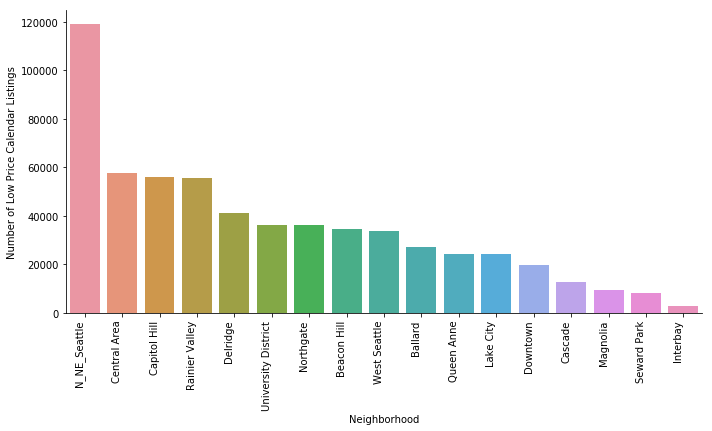

In [11]:
##### Barplot of count for Neighborhoods in each category

## Should Bring along the lat and long here
def price_barplot(df_in,lbl):
    
    df = df_in.copy()
    df = df.groupby('Neighborhood').agg(np.size).reset_index().sort_values('id',ascending = False)
    ax = sns.catplot(x = 'Neighborhood', y = 'id', kind = 'bar', data = df, height = 5,aspect = 2)
    ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=90, ha="right")
    ax.set_ylabels(lbl)
    return

price_barplot(data_exhigh_df, "Number of Extremely High Calendar Price Listings")
price_barplot(data_high_df,   "Number of High Calendar Price Listings")
price_barplot(data_norm_df,   "Number of Normal Calendar Price Listings")
price_barplot(data_low_df,    "Number of Low Price Calendar Listings")


### Not just number but total
###
### Need a lat/long plot (Leaflet) here where points are colored according to price 
### Cannot predict high priced properties based on regression, would be interesting to 
### if there is some feature that indicates really high price, pehaps using lat/lon 
### the very highest priced properties have water view

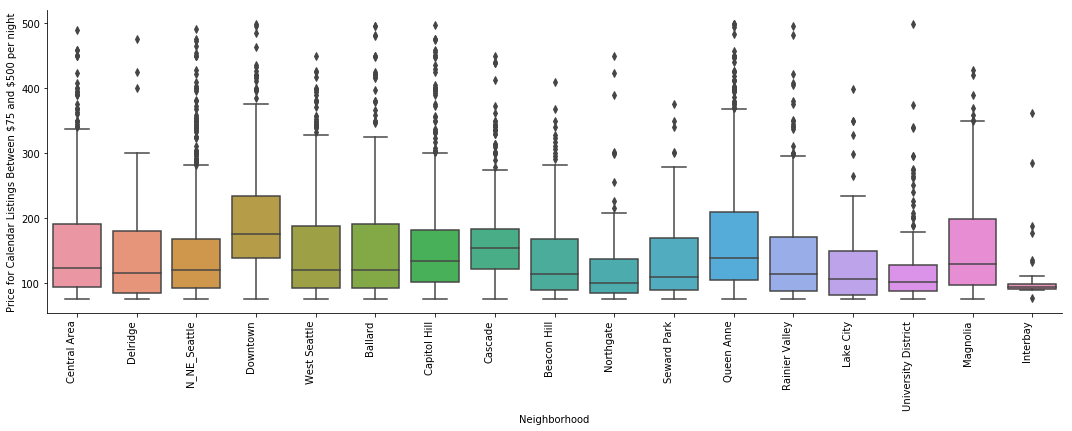

In [12]:
##### Show dependence on neighborhood
avg_price_nbhd_df  =  data_norm_df.groupby(['id','Neighborhood'])['price'].agg(np.mean).to_frame().reset_index()


ax = sns.catplot(x = "Neighborhood", y = "price",kind = "box", orient = "v", data = avg_price_nbhd_df,
                 height = 5,aspect = 3)

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=90, ha="right")
ax.set_ylabels("Price for Calendar Listings Between \$75 and \$500 per night")

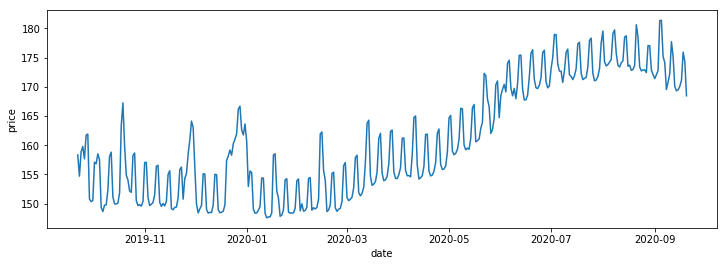

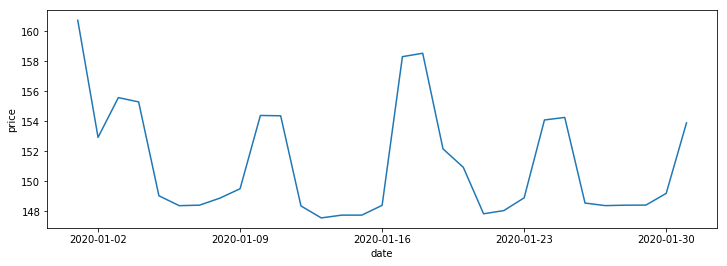

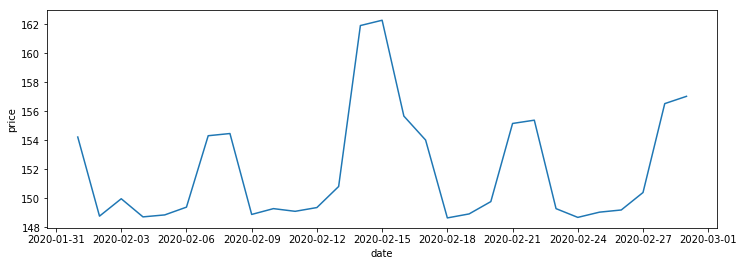

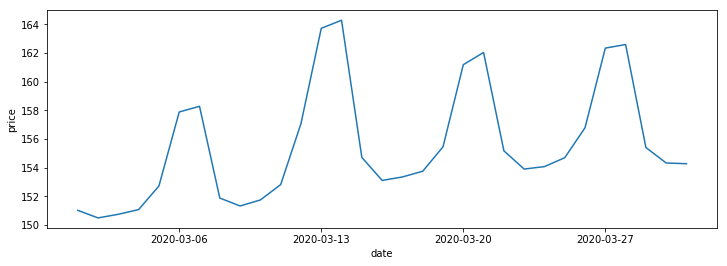

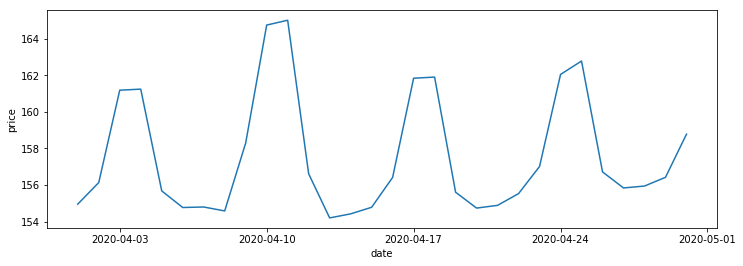

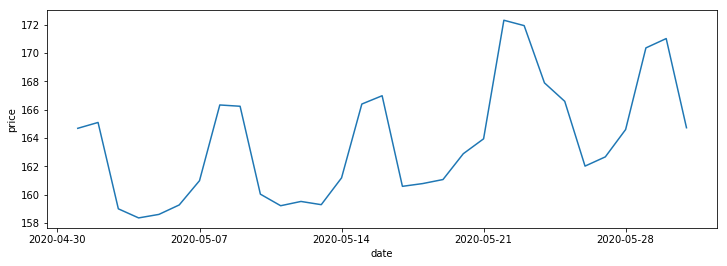

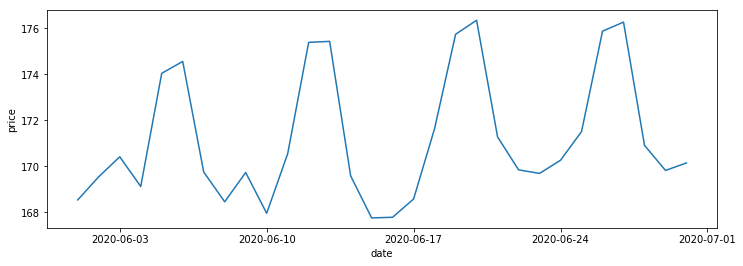

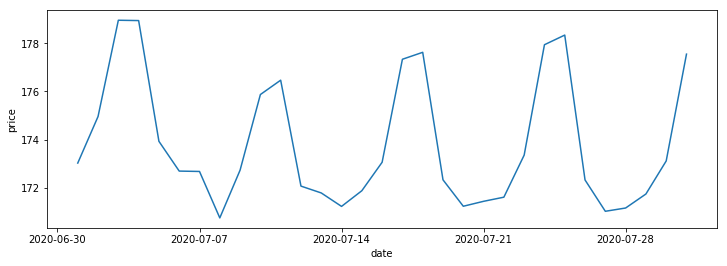

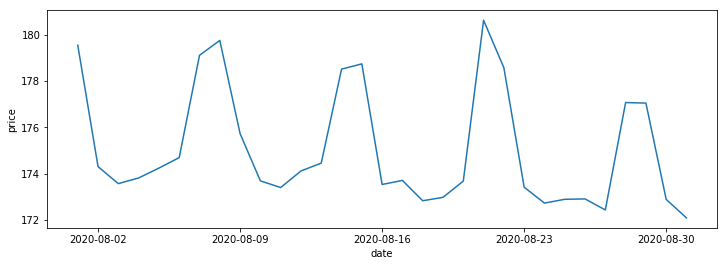

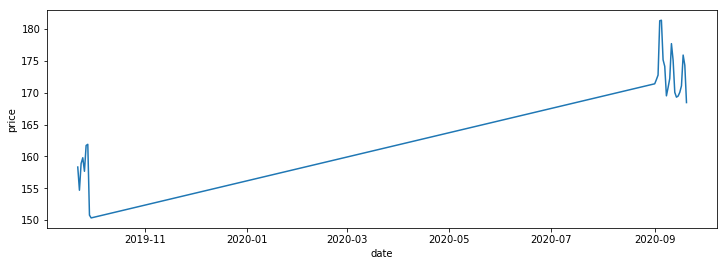

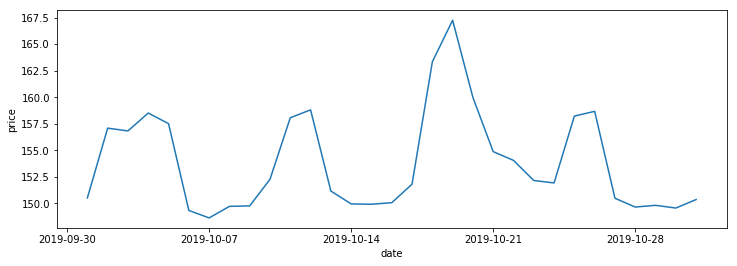

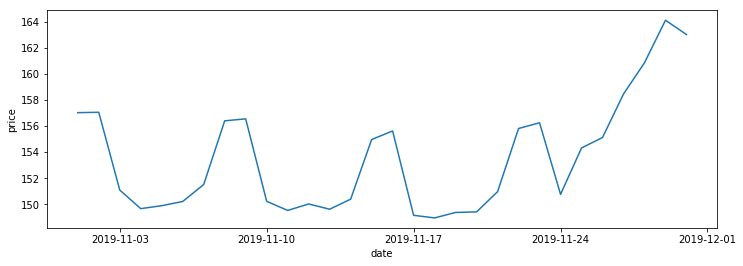

In [13]:
### Do time analysis with each , price range
##### Plot average price over listings at each date 
avg_price_date_df  =  data_norm_df.groupby(['date'])['price'].agg(np.mean).to_frame().reset_index()
plt.figure(figsize=(12, 4))
ax = sns.lineplot(x = "date", y = "price",  data = avg_price_date_df)
for i in range(1,12):
    ## print(type(i))
    
    avg_month_df  = avg_price_date_df[avg_price_date_df.date.map(lambda x: x.month == i)]
    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(x = "date", y = "price",  data = avg_month_df)





### Plot shows higher prices on weekends vs weekdays, prices are also seasonal, 
### e.g. summer prices are higher than winter.
### Therefore Weekend and Month should be added as dummy categorical variables
### for regression to predict time series
### Variables for holidays (or weekends near holidays), like Christmas, Valentine's Day, July 4, Memorial Day  can also be added


,date,price
360,2020-09-16,170.079752
361,2020-09-17,171.097970
362,2020-09-18,175.927741
363,2020-09-19,174.323724
364,2020-09-20,168.465449


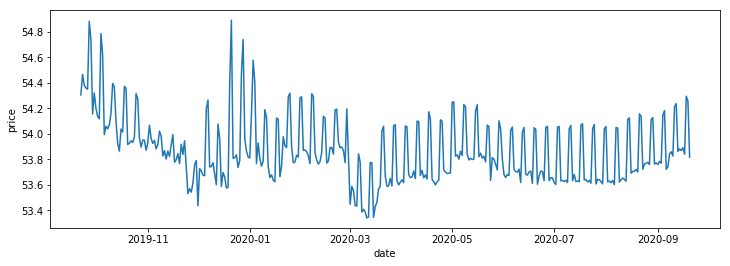

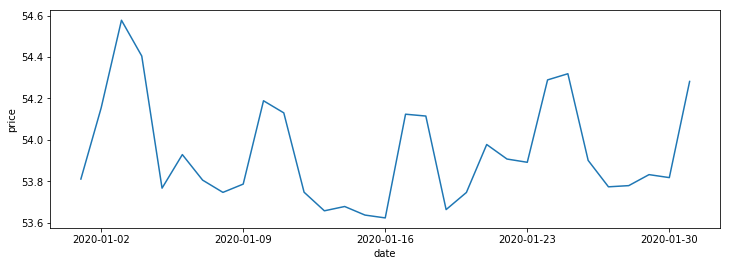

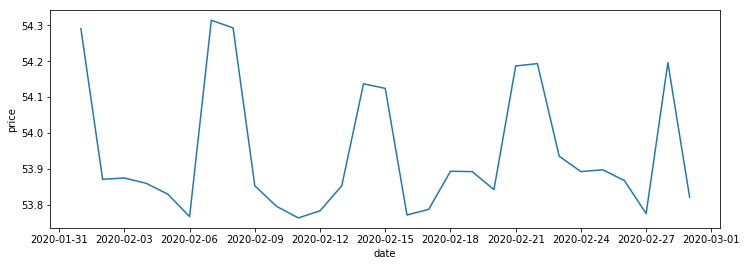

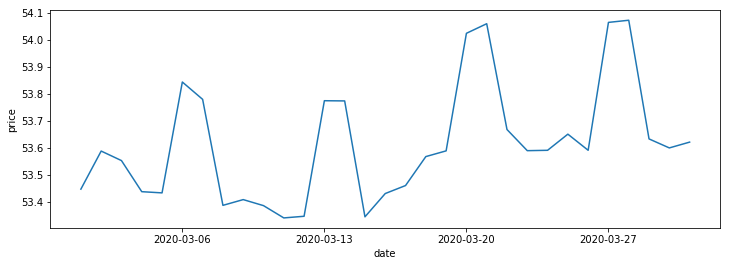

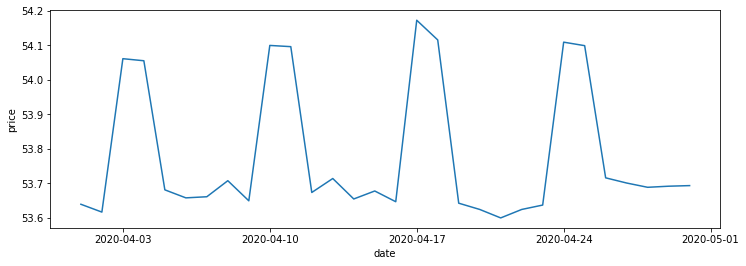

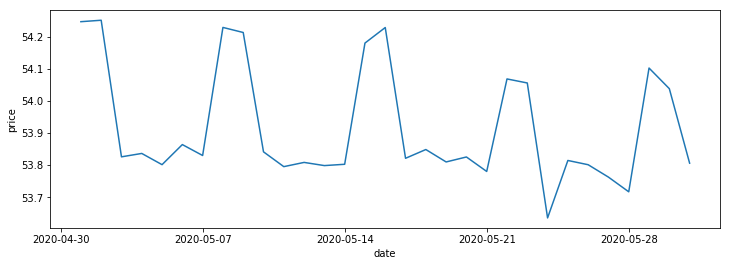

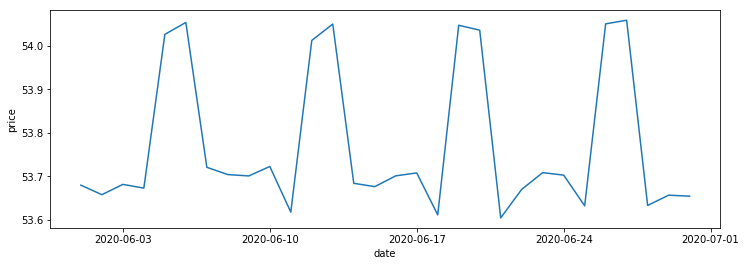

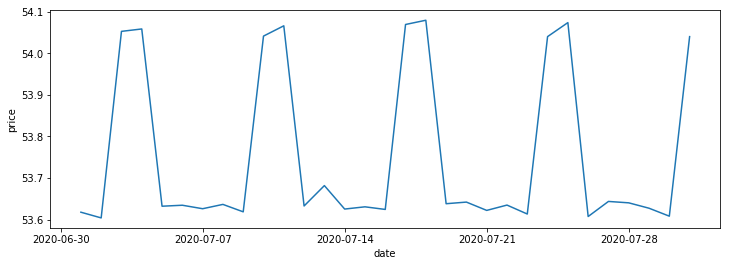

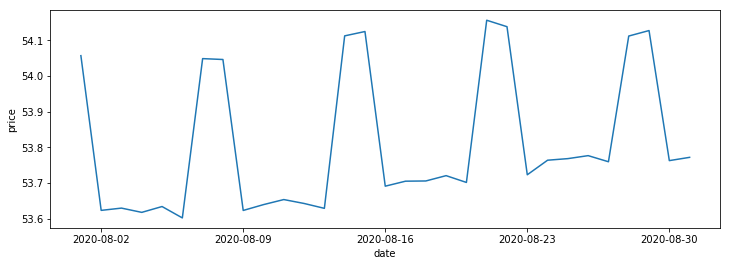

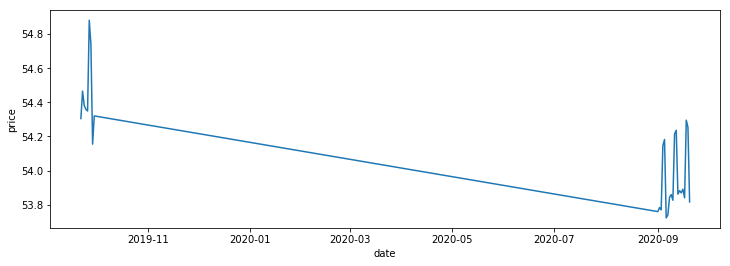

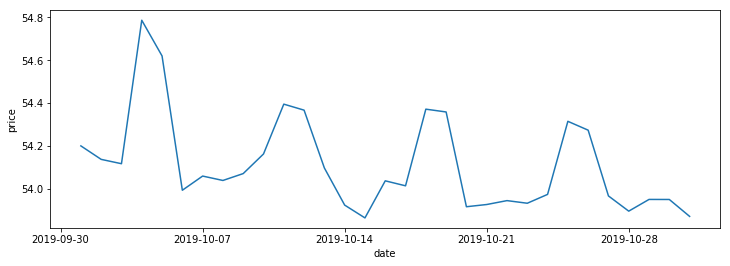

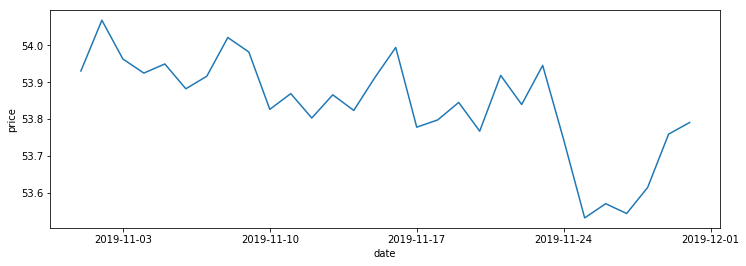

In [15]:
### Run the same but with only low price rentals
avg_price_date_df  =  data_low_df.groupby(['date'])['price'].agg(np.mean).to_frame().reset_index()
plt.figure(figsize=(12, 4))
ax = sns.lineplot(x = "date", y = "price",  data = avg_price_date_df)
for i in range(1,12):
    ## print(type(i))
    
    avg_month_df  = avg_price_date_df[avg_price_date_df.date.map(lambda x: x.month == i)]
    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(x = "date", y = "price",  data = avg_month_df)


In [16]:
##### At the extremes prices are not really seasonal, although weekends are still a bit different
##### than weekdays

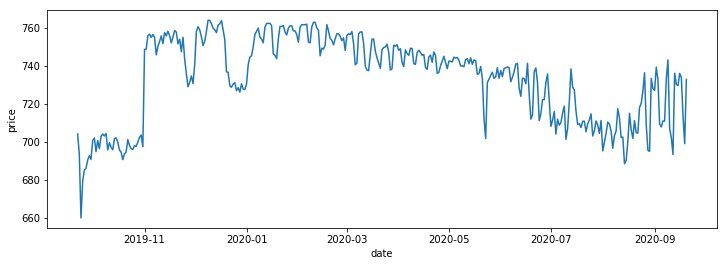

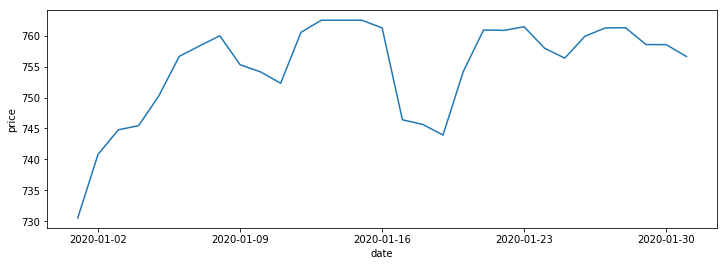

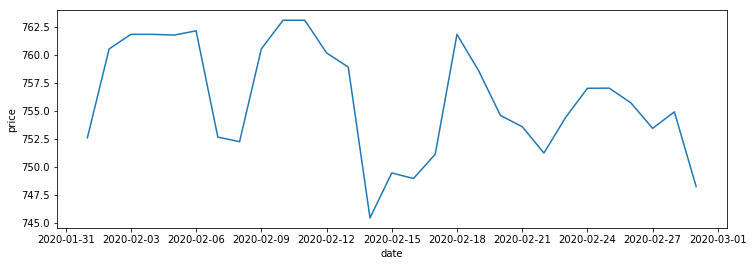

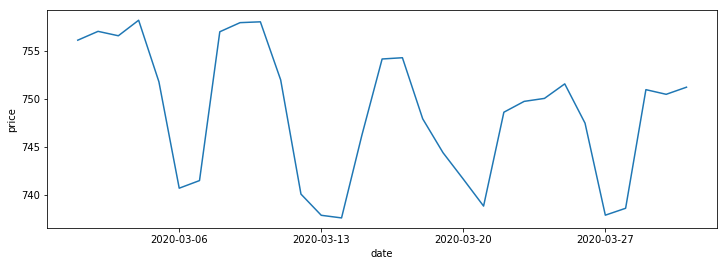

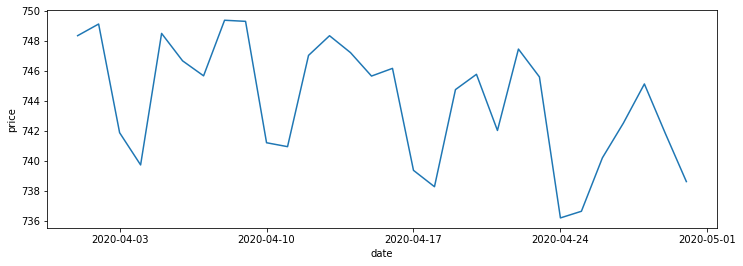

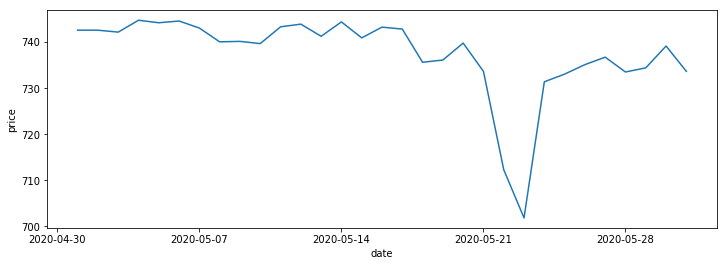

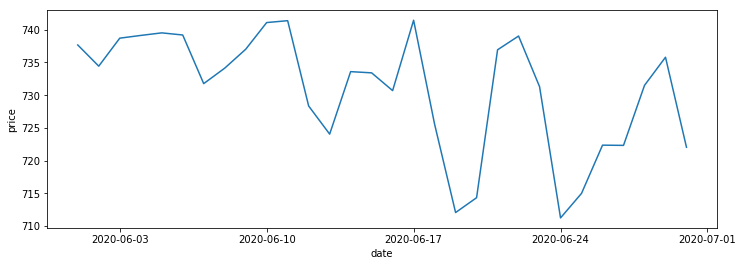

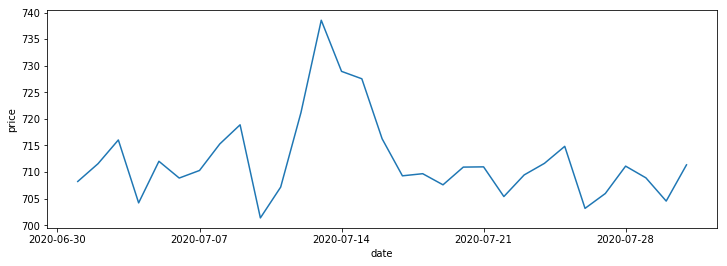

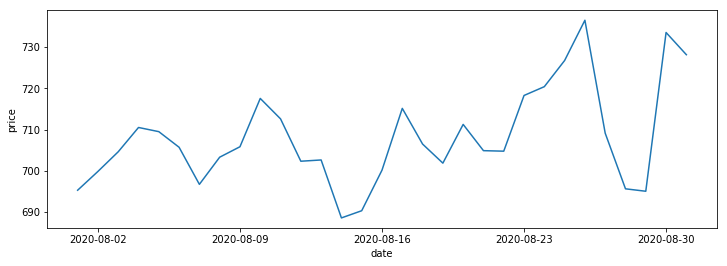

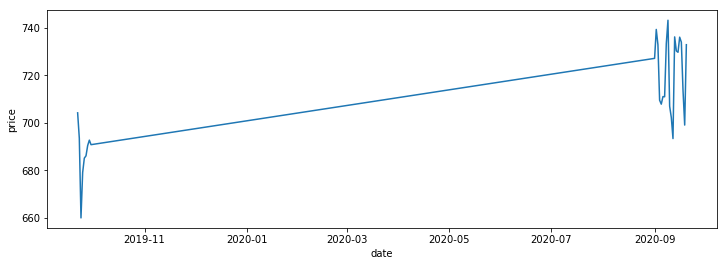

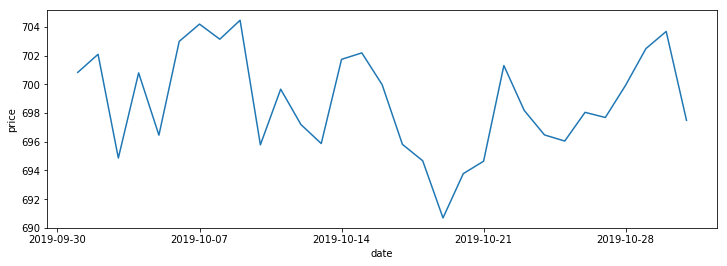

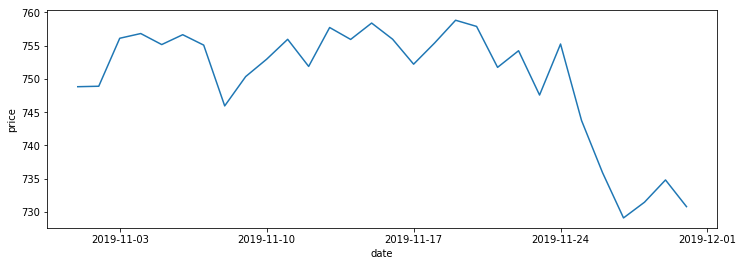

In [17]:
avg_price_date_df  =  data_high_df.groupby(['date'])['price'].agg(np.mean).to_frame().reset_index()
plt.figure(figsize=(12, 4))
ax = sns.lineplot(x = "date", y = "price",  data = avg_price_date_df)
for i in range(1,12):
    ## print(type(i))
    
    avg_month_df  = avg_price_date_df[avg_price_date_df.date.map(lambda x: x.month == i)]
    plt.figure(figsize=(12, 4))
    ax = sns.lineplot(x = "date", y = "price",  data = avg_month_df)